In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
FILENAME = './data/Fall_2015.csv'

* Read, clean, and add  'Enrollment' column
* Reindex by subject and number

In [2]:
df = pd.read_csv(FILENAME).dropna()
drops = ['CRN', 'Term', 'Sched Type', 'Course Section', 'Primary Instructor', 'W']
df = df.drop(drops, 1)
df.ix[:, 'A+':'F'] = df.ix[:, 'A+':'F'].astype(np.int)
df.insert(df.columns.get_loc('Average Grade'), 'Enrollment', df.ix[:, 'A+':'F'].sum(axis=1))

In [3]:
by_number = df.set_index(['Course Subject', 'Course Number'])
by_number.head(10)

Course Title  Enrollment  \
Course Subject Course Number                                               
AAS            100              Intro Asian American Studies          25   
               100              Intro Asian American Studies          28   
               215              US Citizenship Comparatively          29   
ABE            100            Intro Agric & Biological Engrg          40   
               199               Water in the Global Environ          21   
               223              ABE Principles: Machine Syst          63   
               224              ABE Principles: Soil & Water          59   
               430                        Project Management         132   
               466             Engineering Off-Road Vehicles          31   
               488            Bioprocessing Biomass for Fuel          29   

                              Average Grade  A+    A  A-  B+   B  B-  C+  C  \
Course Subject Course Number                                                  
AAS            100                     3.72   0   19   1   2   1   1   0  0   
               100                     3.47   1   13   5   1   3   3   1  0   
               215                     2.81   1    3   5   4   1   6   1  3   
ABE            100                     3.63   0   27   0   0  11   0   0  2   
               199                     3.97   2   18   0   1   0   0   0  0   
               223                     3.50   1   29   9  10   7   0   4  1   
               224                     3.66  19   30   0   4   0   0   1  2   
               430                     3.93   0  119   9   2   1   0   0  0   
               466                     3.49   2   11  11   2   0   2   0  1   
               488                     3.63   6    9   5   4   3   0   2  0   

                              C-  D+  D  D-  F  
Course Subject Course Number                    
AAS            100             0   0  1   0  0  
               100             0   0  0   0  1  
               215             2   1  1   1  0  
ABE            100             0   0  0   0  0  
               199             0   0  0   0  0  
               223             0   1  0   1  0  
               224             0   0  0   0  3  
               430             0   0  0   0  1  
               466             1   0  0   0  1  
               488             0   0  0   0  0

* Create course plotting function
* Make plots for different courses

In [4]:
# Creates a nice plot of a course grade distribution
def plot_course_num(course, name, number):
    grades = course.loc[:, 'A+':'F']
    weighted_avg = np.ma.average(
            course['Average Grade'], weights=course['Enrollment'])
    highest = np.max(grades.values)
    grades.T.plot(kind='bar', ylim=(0, int(highest*1.1)+1), legend=False,
                title='{0} {1} Grades'.format(name, number))
    plt.xlabel('Letter Grade')
    plt.ylabel('Number of Students')
    plt.text(7.75, highest*0.95, 'Average GPA: {0:.2f}'.format(np.round(weighted_avg)), fontsize=12)

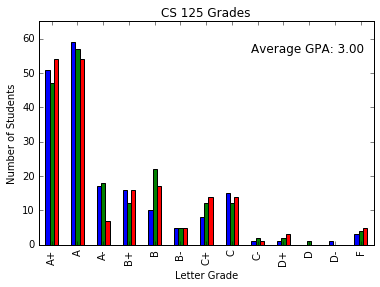

In [5]:
course = 'CS 125'
subject, number = course.split()
plot_course_num(by_number.loc[subject].loc[[int(number)]], subject, int(number))

* Join on duplicate course numbers

In [6]:
enroll = pd.concat((by_number['Enrollment'], by_number['Average Grade']), axis=1)
groups = enroll.groupby(level=[0,1])
courses = groups.apply(lambda d: np.round_(np.ma.average(d['Average Grade'], weights=d['Enrollment']), 2)
                   ).to_frame('Course GPA')
courses.insert(0, 'Enrollment', groups.apply(np.sum)['Enrollment'].astype(np.int))

In [7]:
subjects = ['FR', 'GER']
courses.ix[subjects]

Enrollment  Course GPA
Course Subject Course Number                        
FR             101                   159        3.40
               102                    91        3.18
               104                    22        3.41
GER            101                    47        3.71
               103                    24        2.97
               260                    24        3.76

* Join all course numbers

In [8]:
# Another weighted average but now grouping by major
groups = courses.groupby(level=0)
all_gpa = groups.apply(lambda d:
                       np.ma.average(d['Course GPA'], weights=d['Enrollment']).round(2)
                      ).to_frame('Major GPA')
all_enroll = groups.apply(np.sum).groupby(level=0).apply(np.sum)['Enrollment'].astype(np.int)
course_idx = np.asarray(courses.index.tolist())
course_freq = pd.value_counts(course_idx[:, 0]).to_frame('# Courses')
by_subject = pd.concat([all_enroll, all_gpa, course_freq], axis=1)

In [9]:
by_subject.head()

,Enrollment,Major GPA,# Courses
AAS,82,3.31,2
ABE,375,3.73,7
ACCY,4083,3.34,27
ACE,2280,3.33,25
ACES,416,3.66,2


* Browse courses
* Demo plot of GPA comparison

,Enrollment,Major GPA,# Courses
ABE,375,3.73,7
BIOE,518,3.60,9
NPRE,548,3.48,9
GE,621,3.46,11
AE,1010,3.42,11
CEE,2802,3.42,40
ME,2157,3.38,24
CS,7805,3.29,38
MSE,1272,3.27,23
ECE,5235,3.12,50


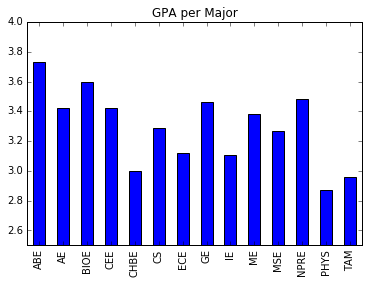

In [10]:
eng_courses = ['ABE', 'AE', 'BIOE', 'CEE', 'CHBE', 'CS', 'ECE',
               'GE', 'IE', 'ME', 'MSE', 'NPRE', 'PHYS', 'TAM']
eng = by_subject.loc[eng_courses]
eng['Major GPA'].plot(kind='bar', ylim=2.5, title='GPA per Major')
eng.sort_values(by=['Major GPA'], ascending=False)